In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from robot_model import *
torch.manual_seed(102)
# mps_device = torch.device("mps")
# Set up the environment
# env = gym.make("Pendulum-v1", render_mode=None)
# num_states = env.observation_space.shape[0]
# num_actions = env.action_space.shape[0]
# upper_bound = env.action_space.high[0]
# lower_bound = env.action_space.low[0]


In [2]:
from gymnasium import spaces

class CDPR4_env(CDPR4):
    def __init__(self, start_state=np.array([.0, .0, 1.0, .0, .0, .0]), desired_state=np.array([.0, .0, 2.0, .0, .0, .0]), pos=np.array([.0, .0, 1.0]), params=params, approx=1, mass=1):
        super().__init__(pos=np.array([.0, .0, 1.]), params=params, approx=1, mass=1)

        self.start_state = start_state.copy()  # start position 1m on Z
        self.cur_state = np.array([.0, .0, 1., .0, .0, .0]) # X=[pos, vel] in control
        self.reward = 0 # reward 0 is 0 error in position, closer position to desired -> higher reward 
        self.desired_state = desired_state
        self.v = np.array([.0, .0, .0])
        self.control = np.array([.0, .0, .0, .0])
    
        self.max_speed = 10
        self.max_force = 45 
        
        self.action_space = spaces.Box(
            low=0.01, high=self.max_force, shape=(4,)
        )
        self.observation_space = spaces.Box(low=np.array([-1.154, -1.404, .0, -self.max_speed, -self.max_speed, -self.max_speed]), 
                                            high=np.array([1.154, 1.404, 3.220,  self.max_speed, self.max_speed, self.max_speed]))
        self._max_episode_steps = 500 # default in gymnasium env is 1000
        self._elapsed_steps = 0
        
    def reset(self):
        state = self.observation_space.sample()
        
        # self.reward = -1 # 1 meter away from desired position
        self._elapsed_steps = 0
        
        self.pos = state[:3].flatten()
        self.v = state[3:].flatten()
        self.control = np.array([.0, .0, .0, .0])
        
        self.reward = np.linalg.norm(self.pos - self.desired_state[:3].flatten())
        
        return state, {}
    
    def step(self, action):
        pos = self.cur_state[:3].flatten()
        vel = self.cur_state[3:].flatten()
        m = self.m

        dt = self.dt
        # u = np.clip(action, .0, self.max_force) # shape should be (4,1)
        # TODO: разобраться  и попробовать убрать клип 
        u = (1+action)*self.max_force
        self.control = u.copy()
        # print(f'pos {pos.shape}')
        # print(f'self.desired_state[:3] {self.desired_state[:3].shape}')
        costs = 1e-3*np.linalg.norm(pos - self.desired_state[:3].flatten()) # reward function includes only position, no velocities
        # TODO: add velocity to cost
        costs += 5e-3*np.linalg.norm(vel - self.desired_state[3:].flatten()) # velocity factor
        # print(f'cost {costs}')
        
        dXdt = self.B() @ u + np.array([.0, .0, .0, .0, .0, -g])
        # print(self.B() @ u)
        new_vel = vel + dXdt[:3].flatten()*dt
        new_pos = pos + vel*dt + 0.5*dXdt[3:].flatten()*dt**2

        self.pos = new_pos
        self.v = new_vel

        state = np.hstack((new_pos, new_vel))
        self.cur_state = state
        
        terminated = np.allclose(self.cur_state, self.desired_state, atol=1e-03) # reached desired position
        
        self._elapsed_steps += 1

        truncated = False
        if self._elapsed_steps >= self._max_episode_steps:
            truncated = True
        
        return state, -costs, terminated, truncated, {} #
        
        

In [3]:
env = CDPR4_env()

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

/Users/damirnurtdinov/miniconda3/envs/cdpr_mujoco/lib/python3.9/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh() # TODO: return back and then scale
        )
        self.max_action = max_action

    def forward(self, state):
        return self.max_action * self.net(state)


In [5]:
# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.state_net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.action_net = nn.Sequential(
            nn.Linear(action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.Tanh()
        )
        self.q_net = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, state, action):
        state_out = self.state_net(state)
        action_out = self.action_net(action)
        concat = torch.cat([state_out, action_out], dim=1)
        return self.q_net(concat)

In [6]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=100000, batch_size=64):
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        indices = np.random.choice(len(self.buffer), self.batch_size)
        batch = [self.buffer[i] for i in indices]

        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.FloatTensor(action),
            torch.FloatTensor(reward).unsqueeze(1),
            torch.FloatTensor(next_state),
            torch.FloatTensor(done).unsqueeze(1)
        )

    def __len__(self):
        return len(self.buffer)

In [7]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        # self.actor.to(mps_device)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        # self.actor_target.to(mps_device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=2e-3)

        self.critic = Critic(state_dim, action_dim)
        # self.critic.to(mps_device)
        self.critic_target = Critic(state_dim, action_dim)
        # self.critic_target.to(mps_device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer()

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, gamma=0.99, tau=0.01):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.sample()

        # Compute the target Q value
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + gamma * target_Q.detach()
        # print(f'target_Q {target_Q}')

        # Get current Q estimate
        current_Q = self.critic(state, action)
        # print(f'current_Q {current_Q}')

        # Compute critic loss
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        # print(f'critic_loss {critic_loss}')

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Training loop
def train_ddpg(env, agent, num_episodes=2000):
    pbar = tqdm(range(num_episodes), desc="Training Progress")

    for episode in pbar:
        prev_state, _ = env.reset() 
        episode_reward = 0
        # print(f"start position {env.pos}: velocity = {env.v}/n robot control {env.control}")

        while True:
            action = agent.select_action(prev_state)
            # action = action + ou_noise()
            action = np.clip(action, lower_bound, upper_bound)

            next_state, reward, done, truncated, _ = env.step(action)
            agent.replay_buffer.push(prev_state, action, reward, next_state, done)

            episode_reward += reward
            state = next_state

            agent.train()

            if done or truncated:
                break
            
            prev_state = state

            
        ep_reward_list.append(episode_reward)    
        # print(f"Robot position {env.pos}: velocity = {env.v}/n robot control {env.control}")
        avg_reward = np.mean(ep_reward_list[-40:])
        avg_reward_list.append(avg_reward)
        
        pbar.set_postfix({
            'Episode Reward': f'{episode_reward:.5f}',
            'Avg Reward (last 40)': f'{avg_reward:.5f}'
        })
        
    return ep_reward_list, avg_reward_list

In [9]:
# Create and train the agent
state_dim = num_states
action_dim = num_actions
max_action = upper_bound
agent = DDPGAgent(state_dim, action_dim, max_action)
ep_rewards, avg_rewards = train_ddpg(env, agent)

Training Progress:  60%|█████▉    | 1198/2000 [1:24:41<56:41,  4.24s/it, Episode Reward=-0.92124, Avg Reward (last 40)=-0.92123]    


KeyboardInterrupt: 

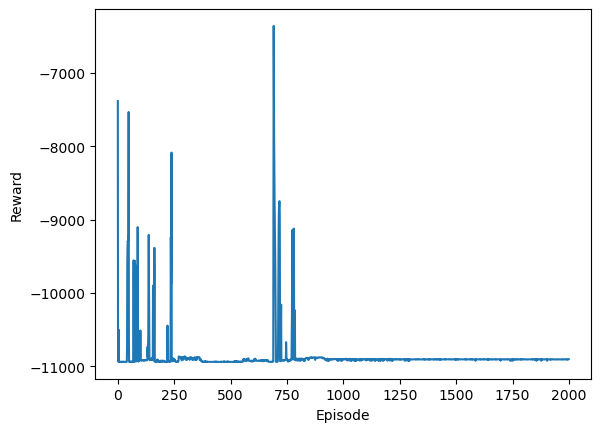

In [ ]:
plt.plot(range(2000), ep_rewards[:2000])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [ ]:
env.cur_state

array([ 1.14732762, -1.40348507,  3.21993738,  0.        ,  0.        ,
        0.        ])

In [ ]:
env.control

array([1010.4726, 2070.    ,   45.45  ,   45.45  ], dtype=float32)